In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os,random, math, psutil, pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

import json

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import gc

pd.set_option('max_columns', 100)

# 4. Make X and y

In [2]:
train = pd.read_pickle('../data/processed/train.pkl')

# rolling average by day
train = train.set_index('timestamp')
train['meter_reading'] = train['meter_reading'].rolling('D').mean()

# cols = ['hour', 'dayofyear', 'weekofyear', 'month']
# train[cols] = train[cols].astype('category')

def make_X_y(train):    
    X = train.drop(['meter_reading'], axis=1)
    y = np.log1p(train['meter_reading'])
    return X, y
X, y = make_X_y(train)

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20216100 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 17 columns):
 #   Column             Dtype   
---  ------             -----   
 0   building_id        int16   
 1   meter              int8    
 2   site_id            int8    
 3   primary_use        category
 4   square_feet        int32   
 5   year_built         float64 
 6   floor_count        float64 
 7   air_temperature    float64 
 8   cloud_coverage     float64 
 9   dew_temperature    float64 
 10  precip_depth_1_hr  float64 
 11  wind_speed         float64 
 12  hour               int8    
 13  dayofyear          int16   
 14  weekofyear         int8    
 15  month              int8    
 16  beaufort_scale     float64 
dtypes: category(1), float64(8), int16(2), int32(1), int8(5)
memory usage: 1.6 GB


In [4]:
y

timestamp
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
                         ...   
2016-12-31 23:00:00    6.113272
2016-12-31 23:00:00    6.113254
2016-12-31 23:00:00    6.113237
2016-12-31 23:00:00    6.113225
2016-12-31 23:00:00    6.113208
Name: meter_reading, Length: 20216100, dtype: float64

# 5. Light gradient boosting

### 5.1 KFold without shuffling

In [5]:
%%time
models = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X):
    
    # split train and test set
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    num_train, num_feature = X_train.shape

    # create dataset for lightgbm
    # set free_raw_data=False to reuse data
    lgb_train = lgb.Dataset(X_train, y_train, weight=None, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, weight=None, free_raw_data=False)

    # specify your configurations as a dict
    params = {
              "objective": "regression",
              "boosting": "gbdt",
              "num_leaves": 1280,
              "learning_rate": 0.1,
              "feature_fraction": 0.85,
              "reg_lambda": 2,
              "metric": "rmse"}

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=70,
                      valid_sets=lgb_eval,  # eval testing data
                      categorical_feature=['primary_use', 'hour', 'dayofyear', 'weekofyear', 'month'], 
                      verbose_eval=25, 
                      early_stopping_rounds=50)
    
    #ypred = model.predict(X_test)
    #plt.plot(ypred/y_test)
    # model.save_model('')
    
    models.append(model)
    
# models.save_model('models-5fold.txt')

Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.51385
[50]	valid_0's rmse: 1.61627
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.853301
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 0.430712
[50]	valid_0's rmse: 0.506528
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.398003
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.24965
[50]	valid_0's rmse: 1.25773
Early stopping, best iteration is:
[14]	valid_0's rmse: 1.23709
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 0.264243
[50]	valid_0's rmse: 0.298288
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.24776
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 0.553591
[50]	valid_0's rmse: 0.525789
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 0.524076
Wall time: 6min 42s


In [6]:
def print_results(scores):
    [print(i) for i in (np.round(scores, 3))]
    avg = np.round(np.mean(scores), 3)
    print(f'average: {avg}')

def plot_importances(models):
    for model in models:
        fig, axes = plt.subplots(figsize=(12, 10))
        lgb.plot_importance(model, ax=axes)
        plt.show()

## Metric: sum absolute error

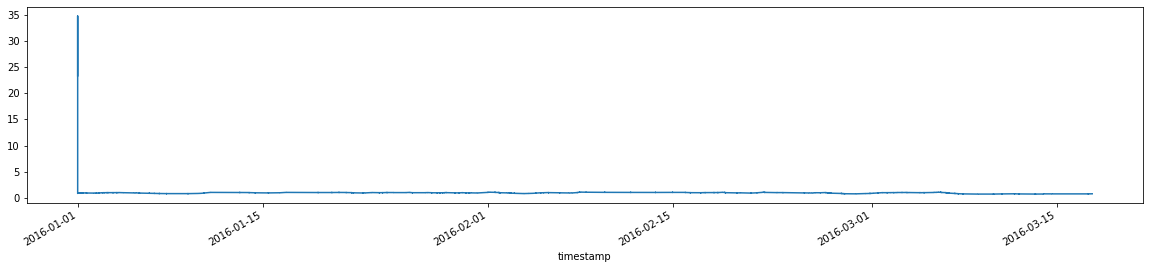

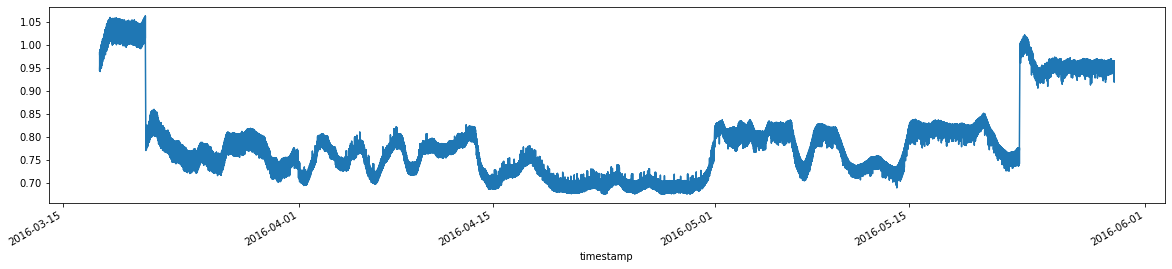

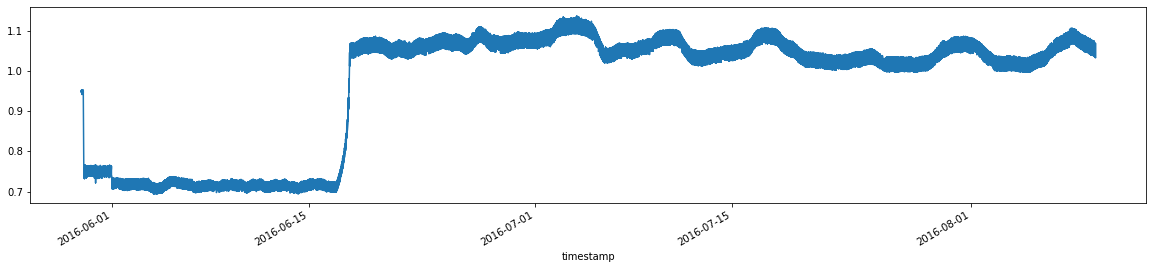

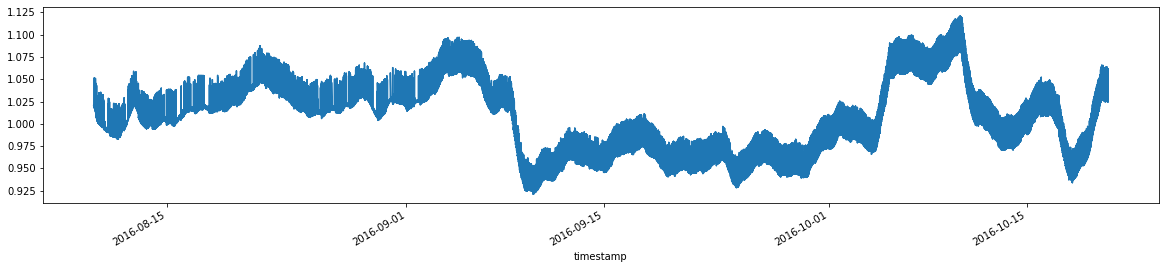

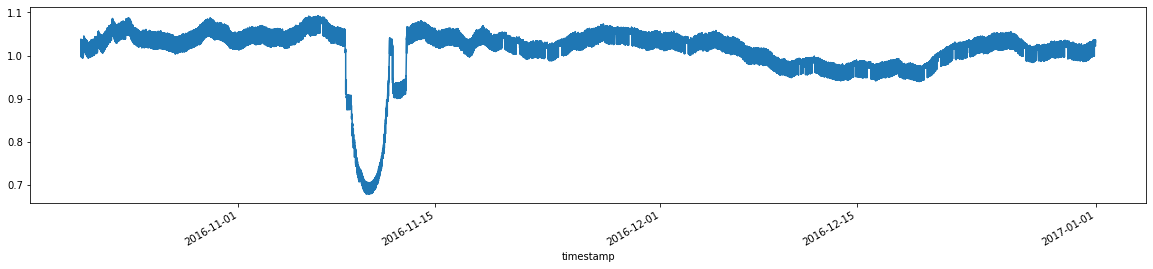

In [7]:
kf = KFold(n_splits=5, shuffle=False)
scores = []
i = 0

for train_index, test_index in kf.split(X):
          
    X_test = X.iloc[test_index]    
    y_test = y.iloc[test_index]
    
    y_pred = models[i].predict(X_test)
    i += 1
    
    fig, axes = plt.subplots(figsize=(20, 4))
    (y_pred / y_test).plot()  
    
    scores.append(np.sum(np.absolute(y_test - y_pred)) / np.sum(y_test))
    

Scores:
0.085
0.212
0.13
0.034
0.048
average: 0.102


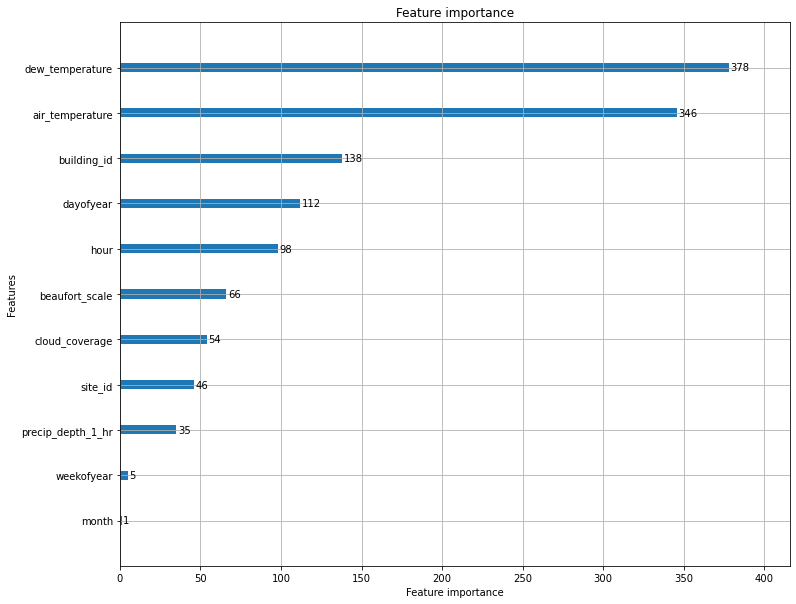

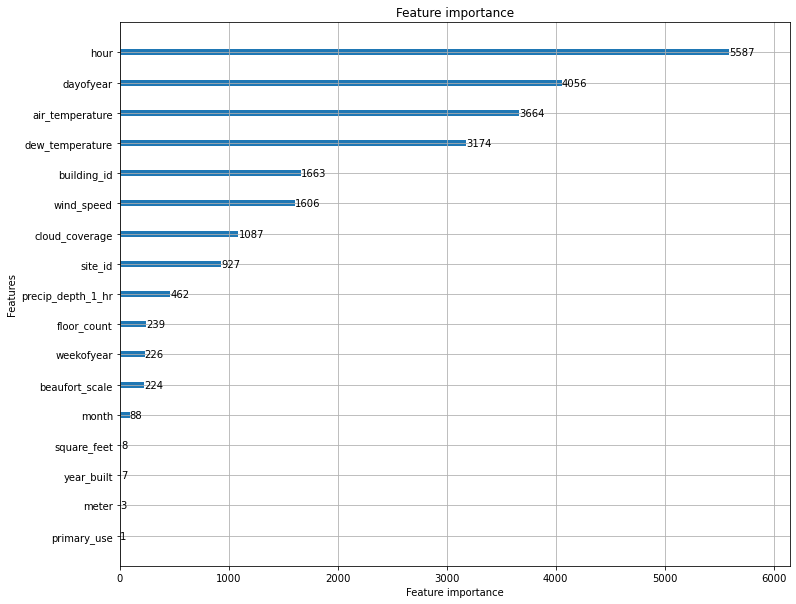

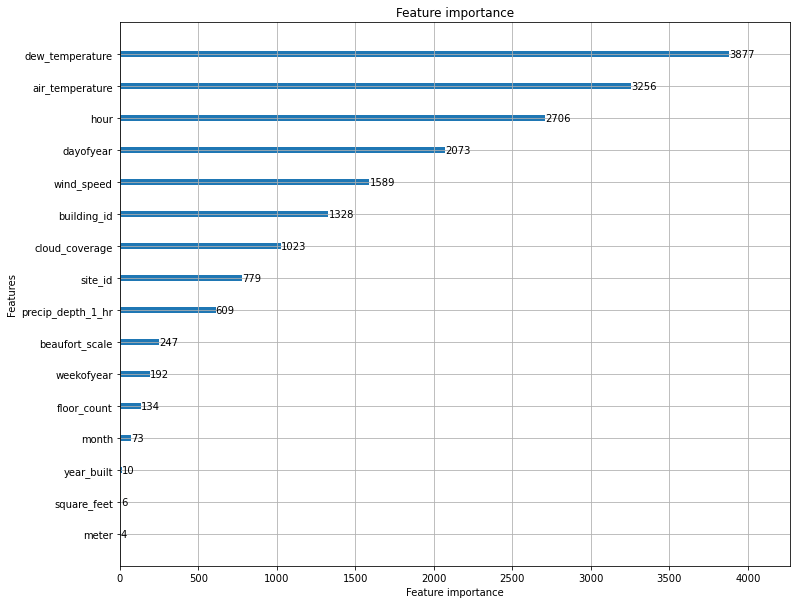

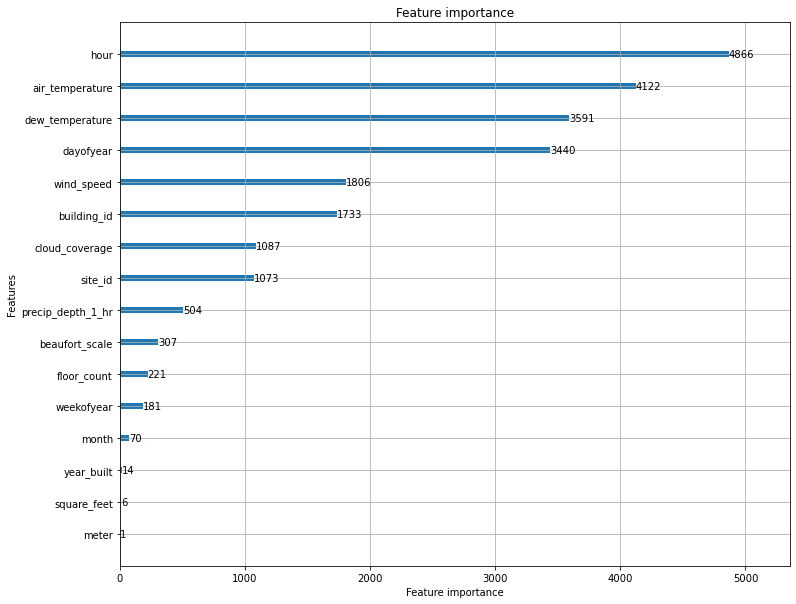

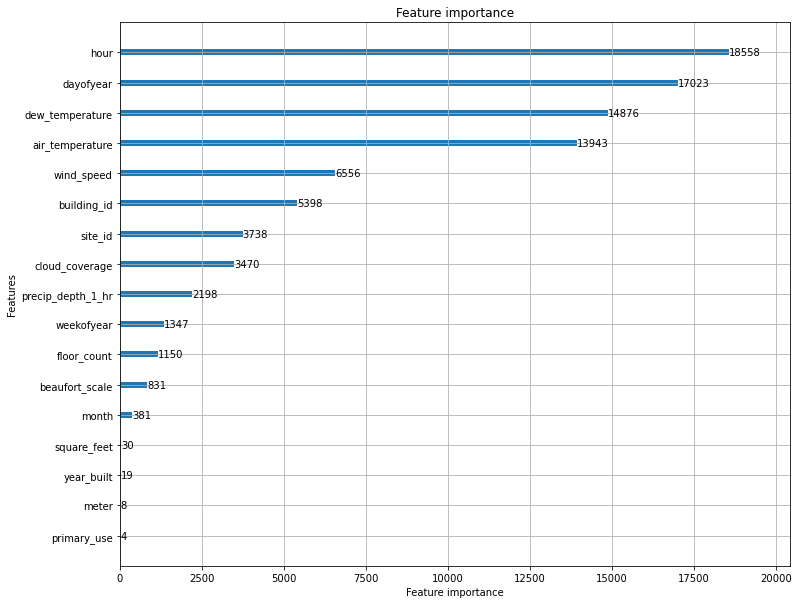

In [8]:
print('Scores:')
print_results(scores)
plot_importances(models)

## Metric: mean squared errra

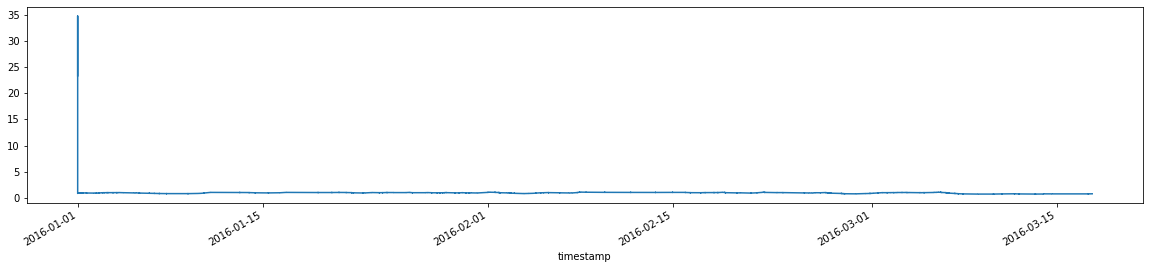

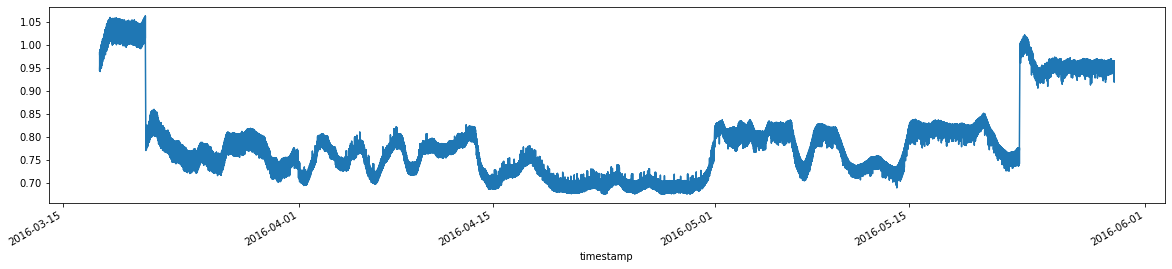

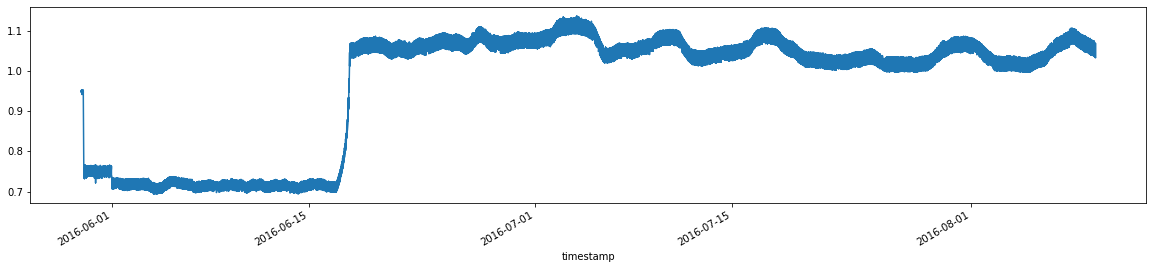

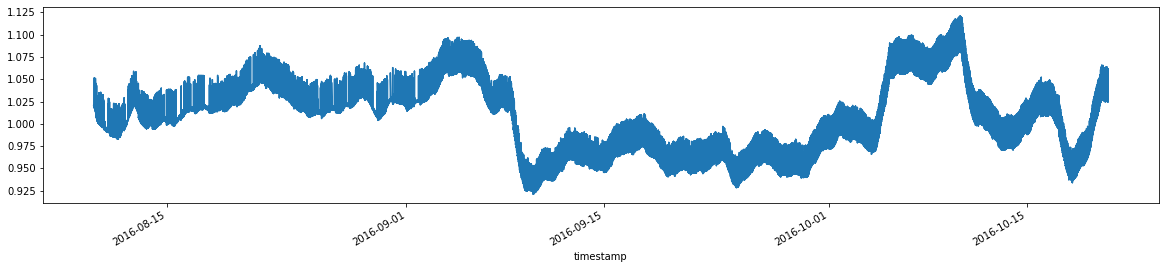

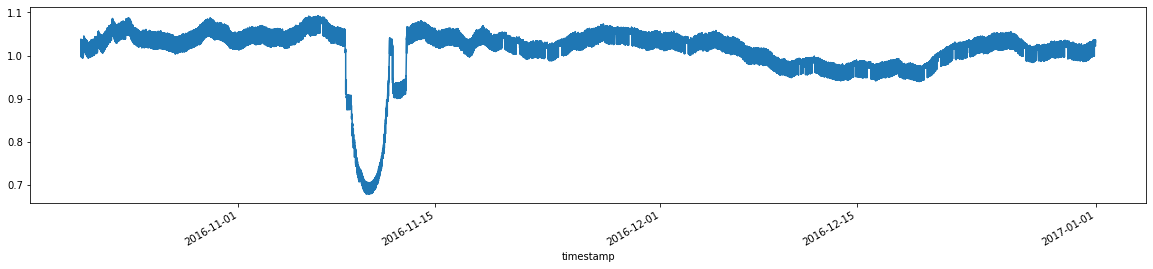

In [9]:
kf = KFold(n_splits=5, shuffle=False)
scores = []
i = 0

for train_index, test_index in kf.split(X):
          
    X_test = X.iloc[test_index]    
    y_test = y.iloc[test_index]
    
    y_pred = models[i].predict(X_test)
    scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    i += 1
   
    fig, axes = plt.subplots(figsize=(20, 4))
    (y_pred / y_test).plot()  

Scores:
0.878
1.937
1.302
0.249
0.494
average: 0.972


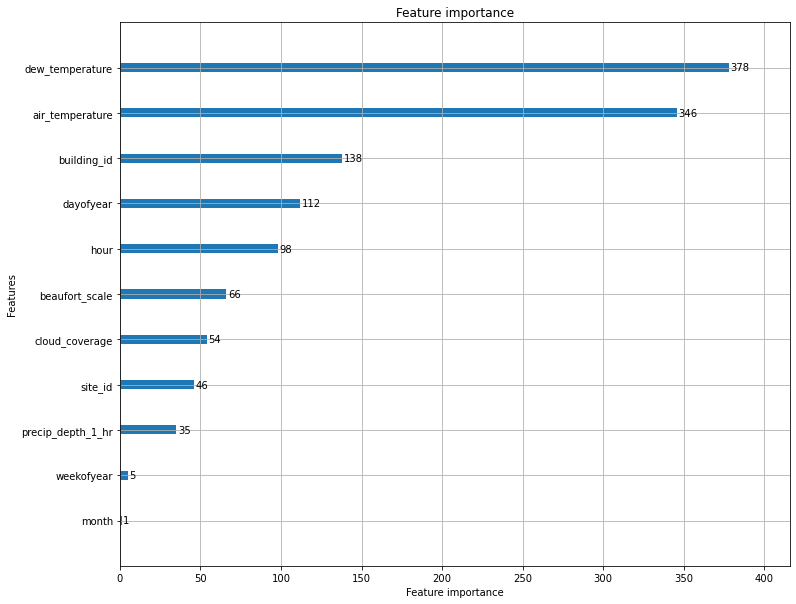

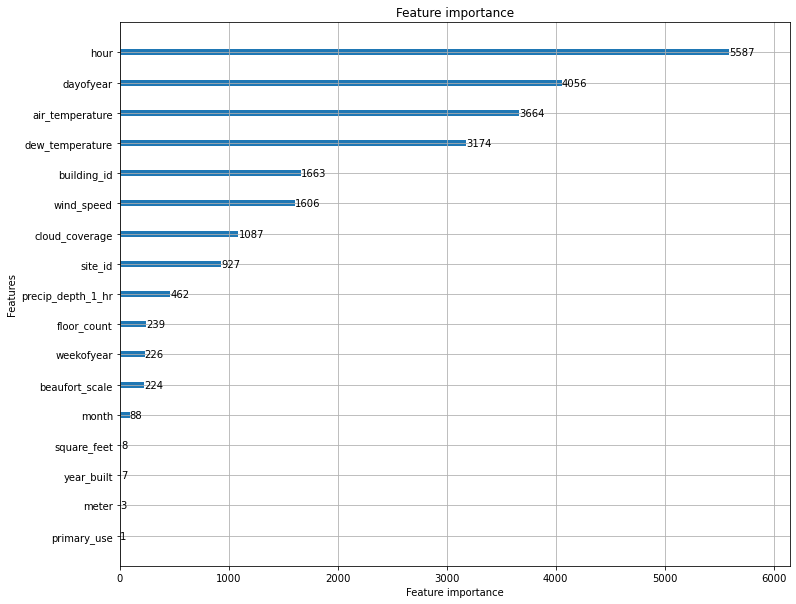

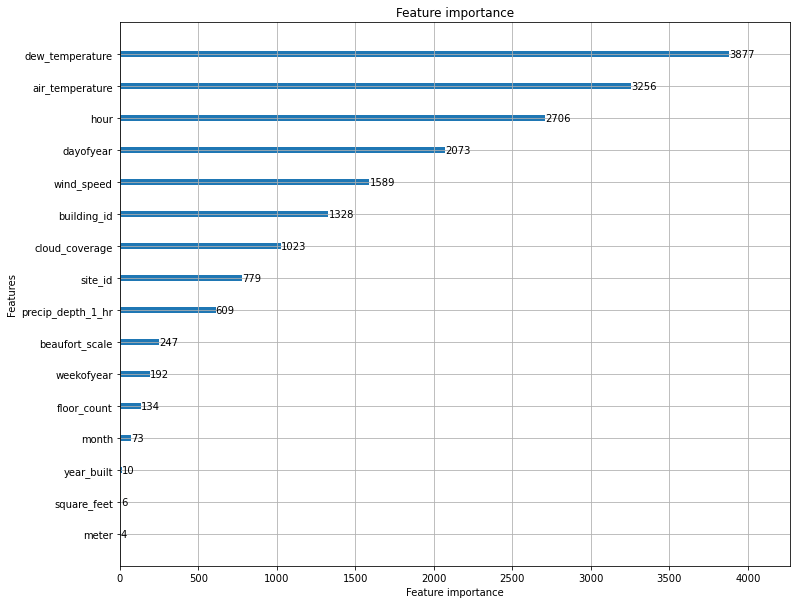

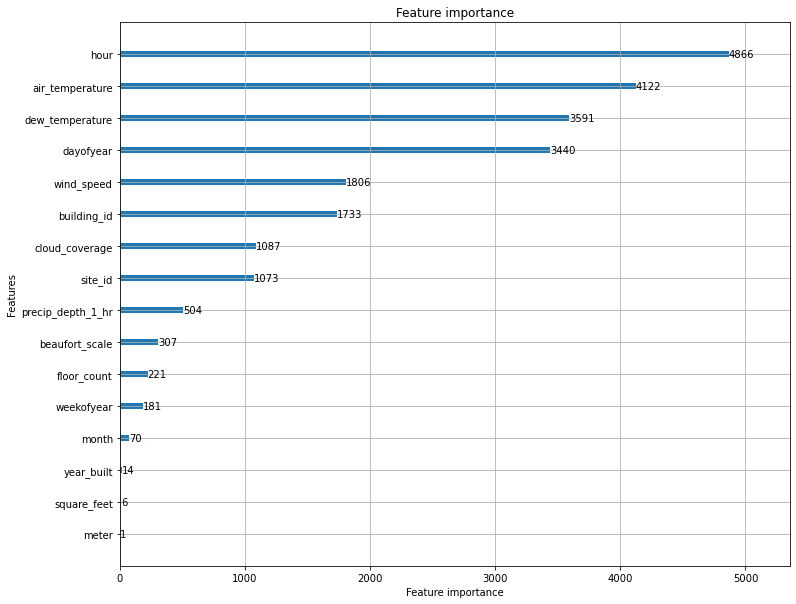

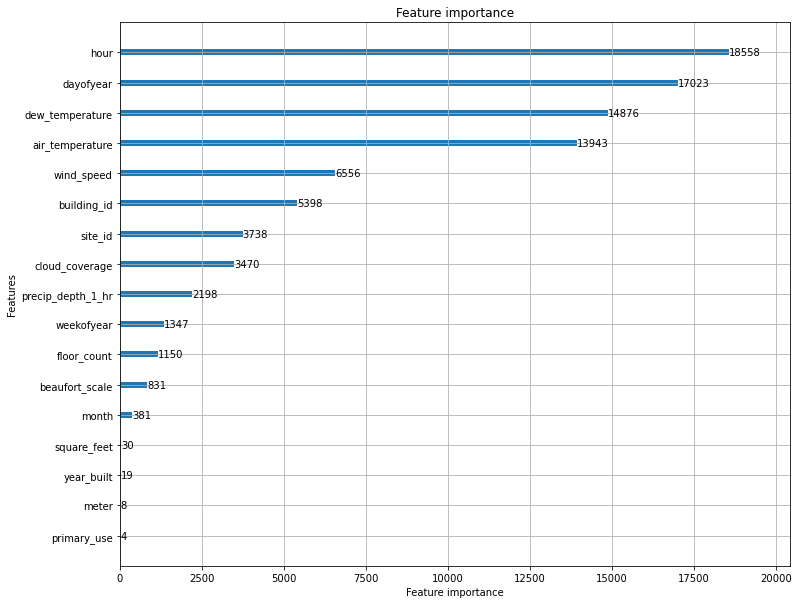

In [10]:
print('Scores:')
print_results(scores)
plot_importances(models)

### 5.2 TimeSeriesSplit
Its cross validation behavious is illustrated below.

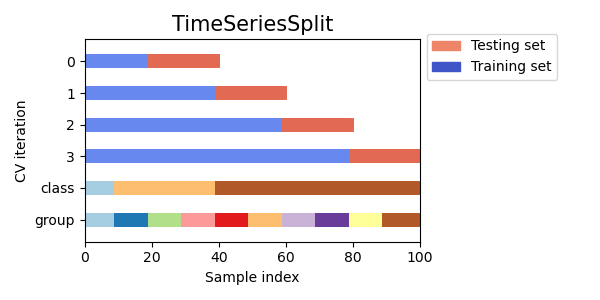

In [11]:
%%time
models = []

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    
    # split train and test set
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    num_train, num_feature = X_train.shape

    # create dataset for lightgbm
    # set free_raw_data=False to reuse data
    lgb_train = lgb.Dataset(X_train, y_train, weight=None, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, weight=None, free_raw_data=False)

    # specify your configurations as a dict
    params = {
              "objective": "regression",
              "boosting": "gbdt",
              "num_leaves": 1280,
              "learning_rate": 0.1,
              "feature_fraction": 0.85,
              "reg_lambda": 2,
              "metric": "rmse"}

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=70,
                      valid_sets=lgb_eval,  # eval training data
                      categorical_feature="auto",
                      verbose_eval=25, 
                      early_stopping_rounds=50)
    
    models.append(model)

Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.81451
[50]	valid_0's rmse: 1.83141
Early stopping, best iteration is:
[1]	valid_0's rmse: 1.68756
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.27342
[50]	valid_0's rmse: 1.275
Early stopping, best iteration is:
[11]	valid_0's rmse: 1.27081
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 0.242824
[50]	valid_0's rmse: 0.368164
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.114477
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 0.309099
[50]	valid_0's rmse: 0.362534
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.271647
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 0.540548
[50]	valid_0's rmse: 0.565757
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.522689
Wall time: 3min 54s


## Metric: mean squared error

Scores:
1.688
1.271
0.114
0.272
0.523
average: 0.773


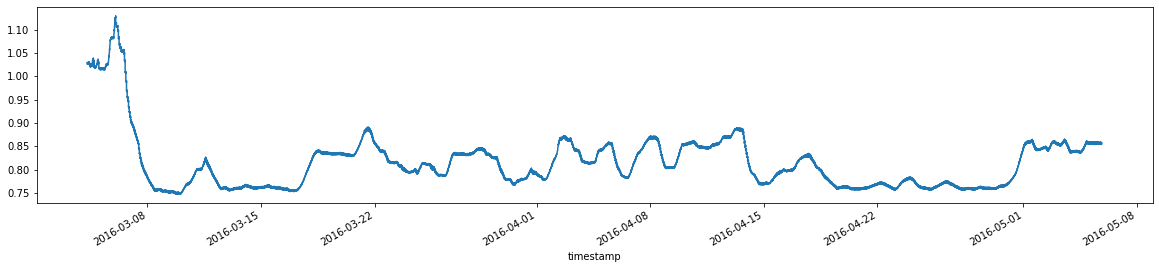

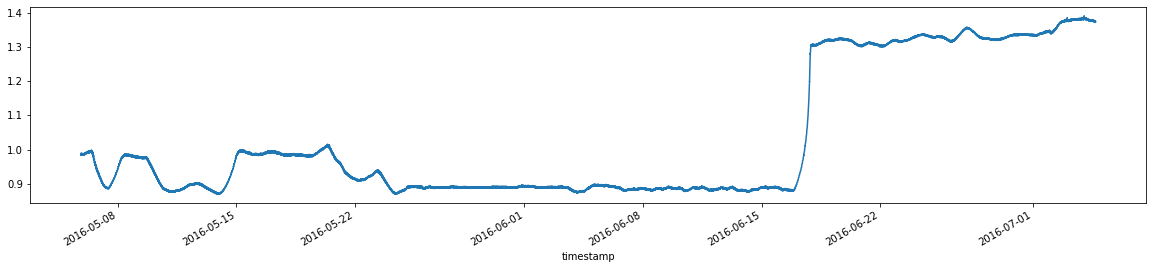

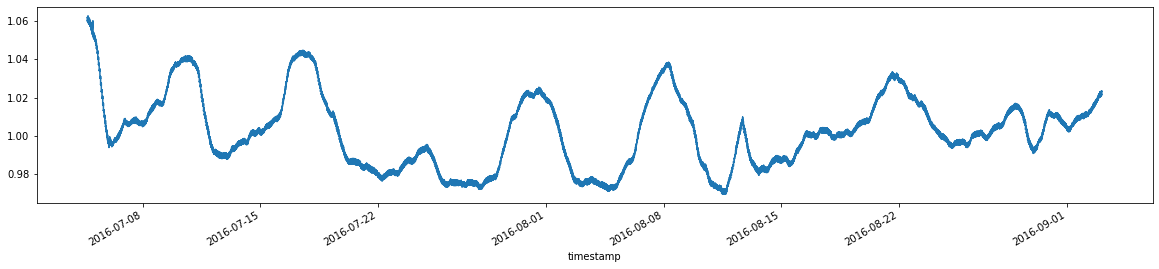

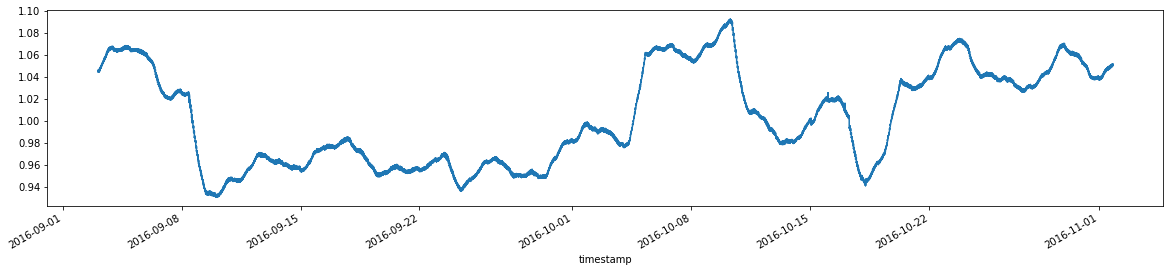

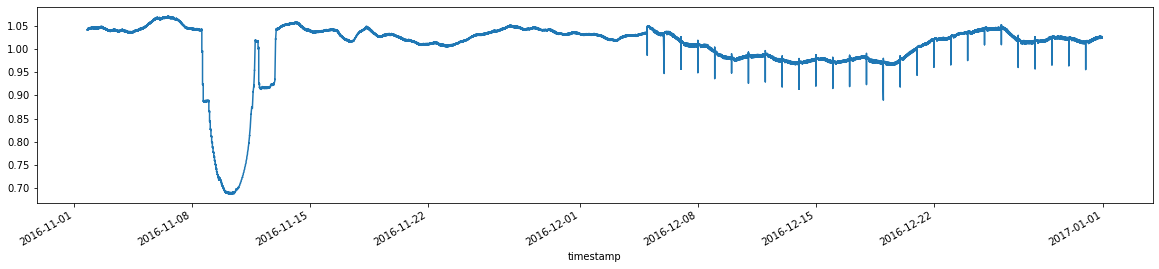

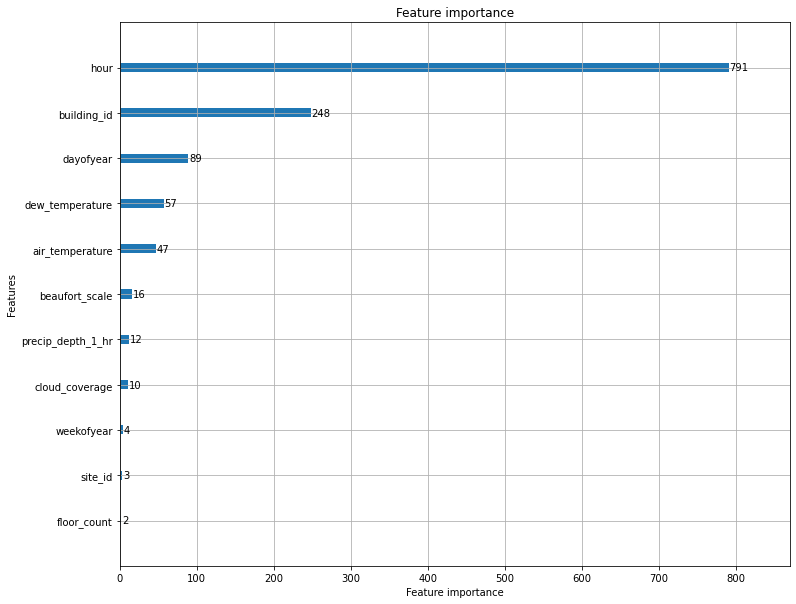

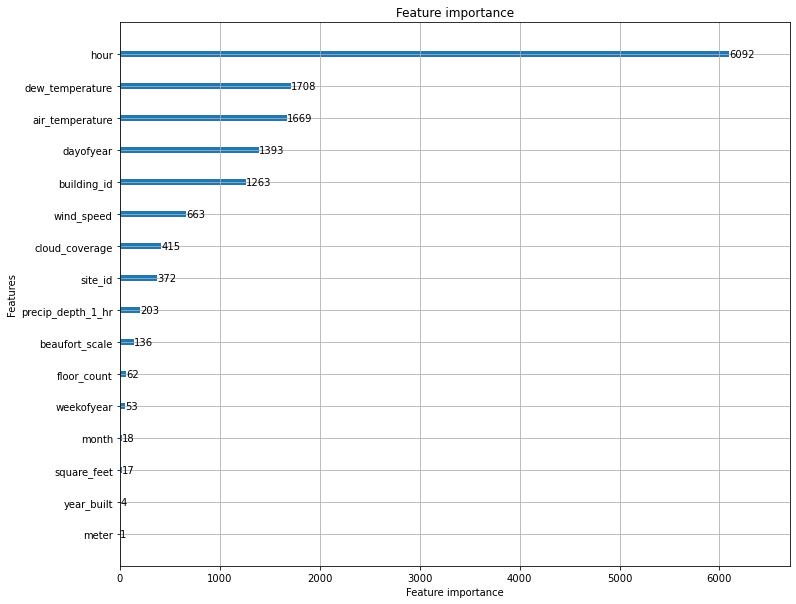

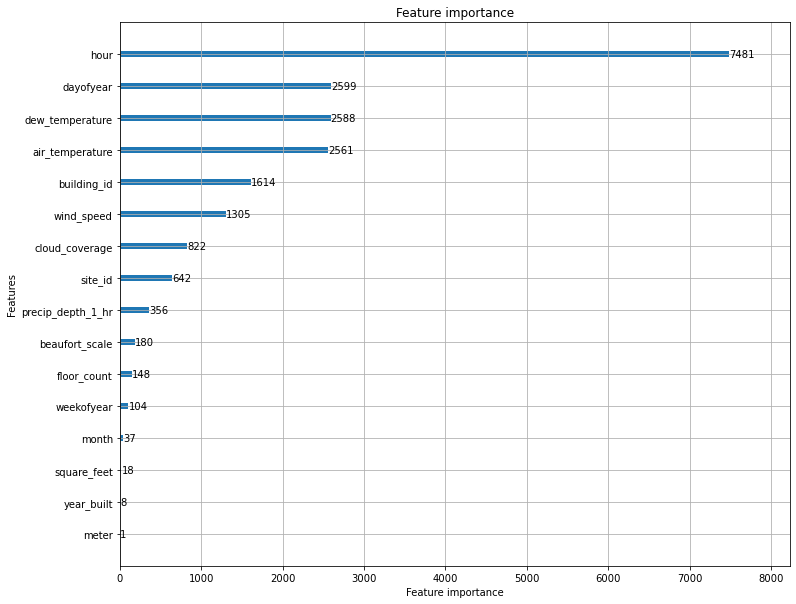

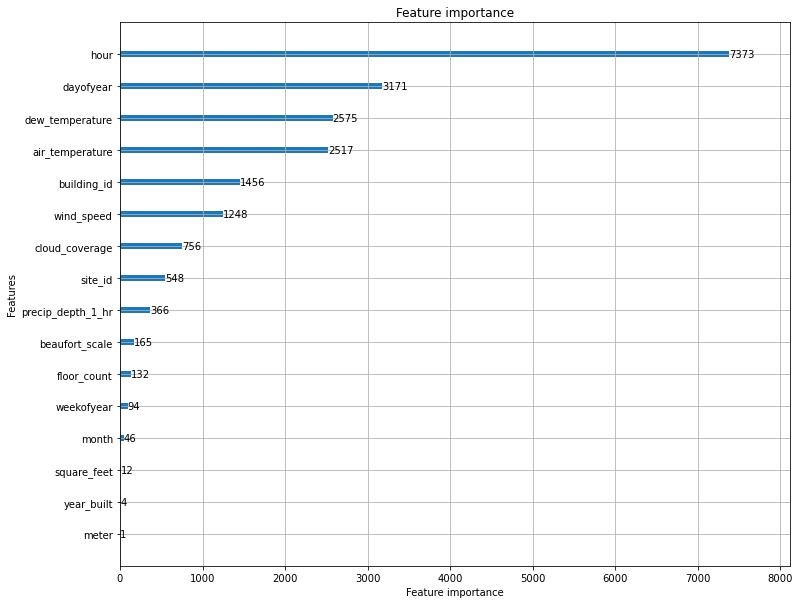

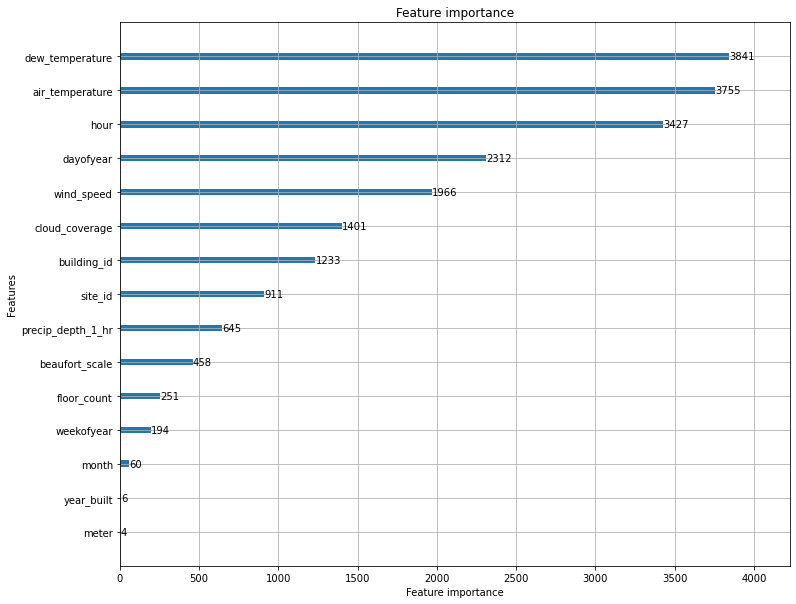

In [12]:
i = 0
scores = []
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
          
    X_test = X.iloc[test_index]    
    y_test = y.iloc[test_index]
    
    y_pred = models[i].predict(X_test)
    scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    i += 1
    
    fig, axes = plt.subplots(figsize=(20, 4))
    (y_pred / y_test).plot()    

print('Scores:')
print_results(scores)
plot_importances(models)

## Metric: sum absolute error

Scores:
0.192
0.141
0.015
0.04
0.044
average: 0.086


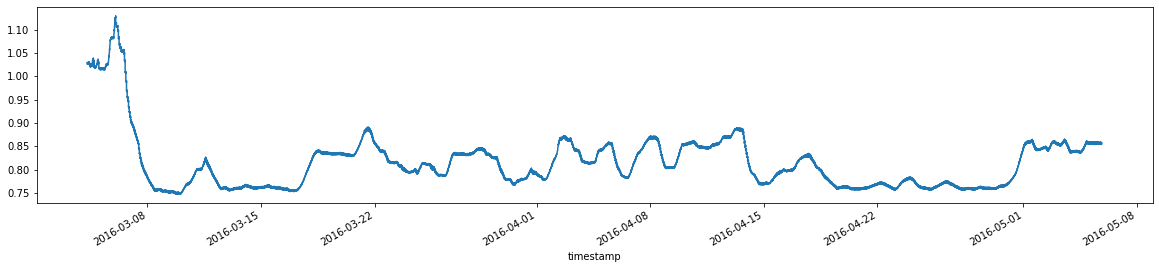

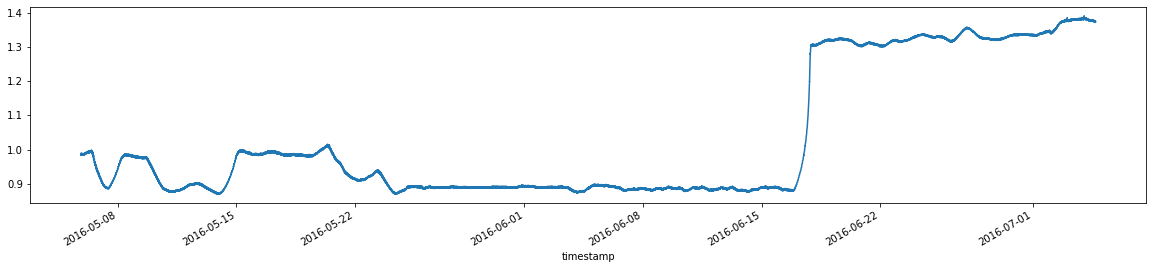

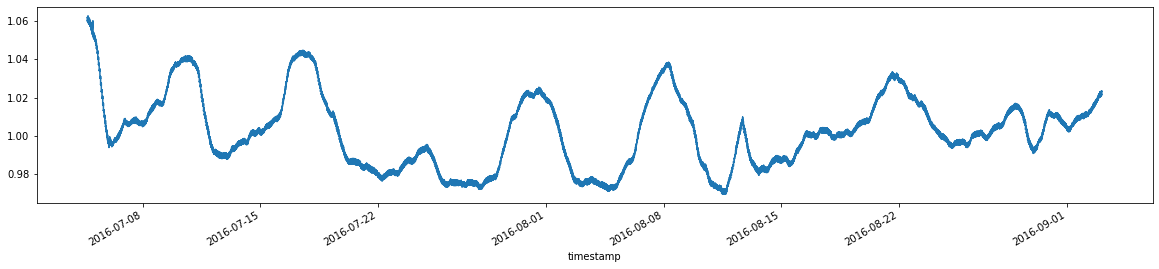

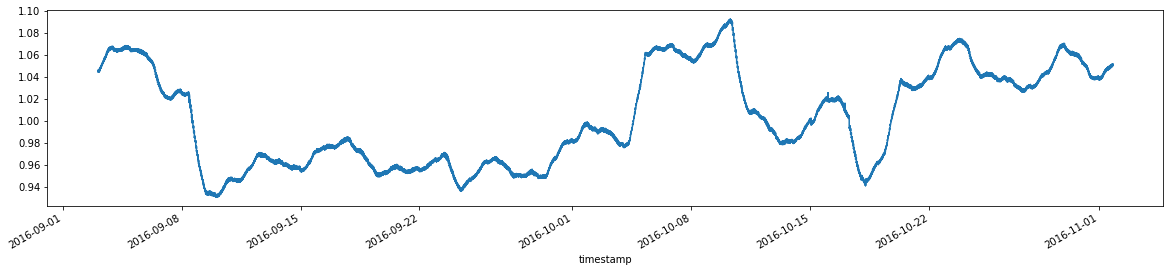

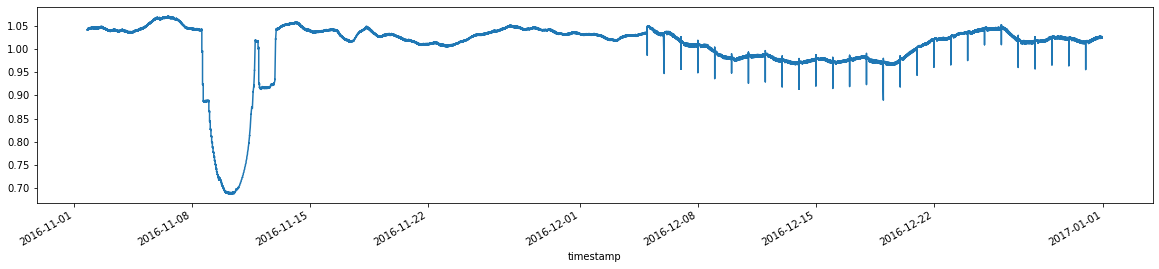

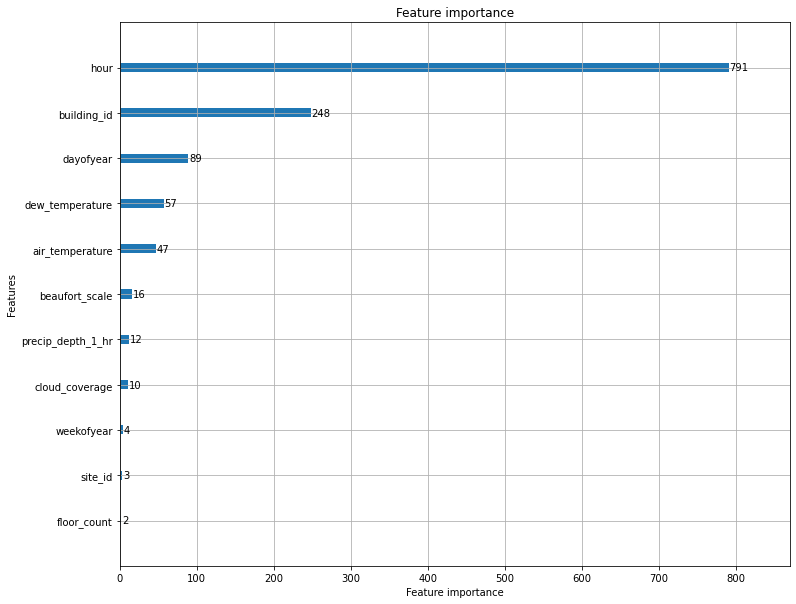

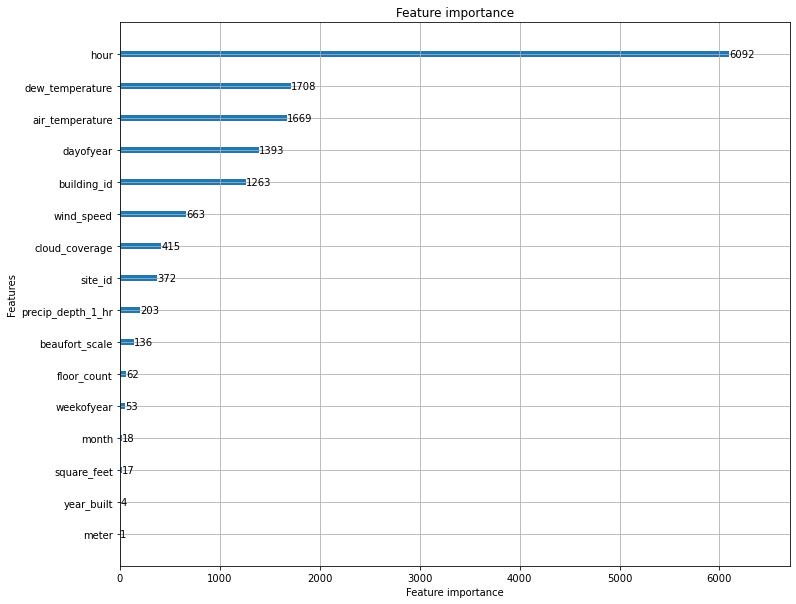

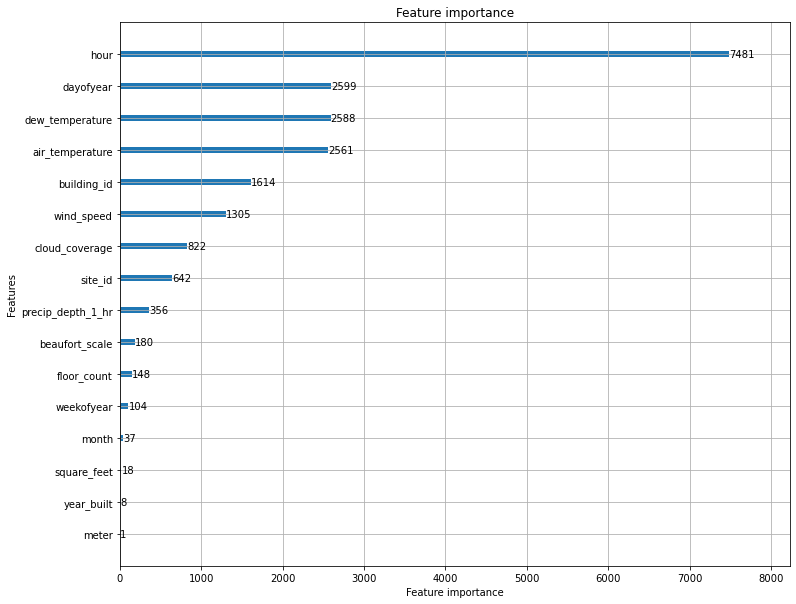

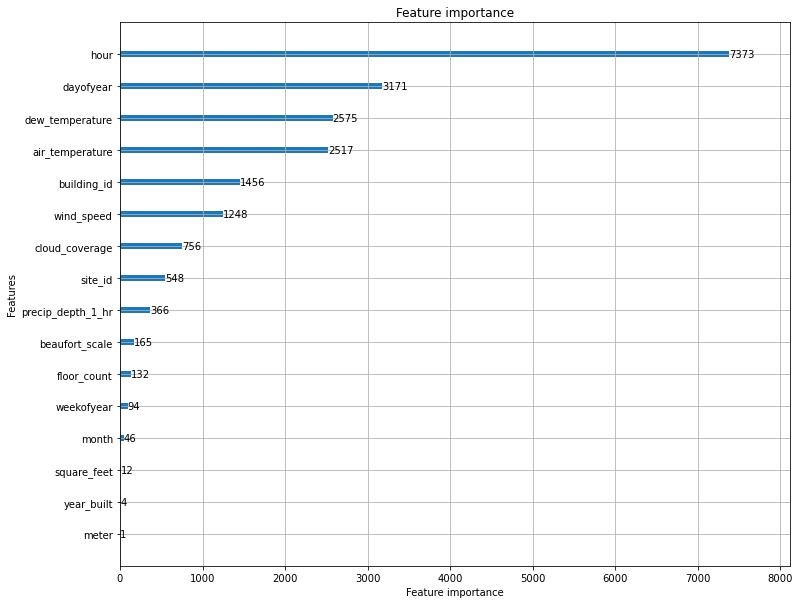

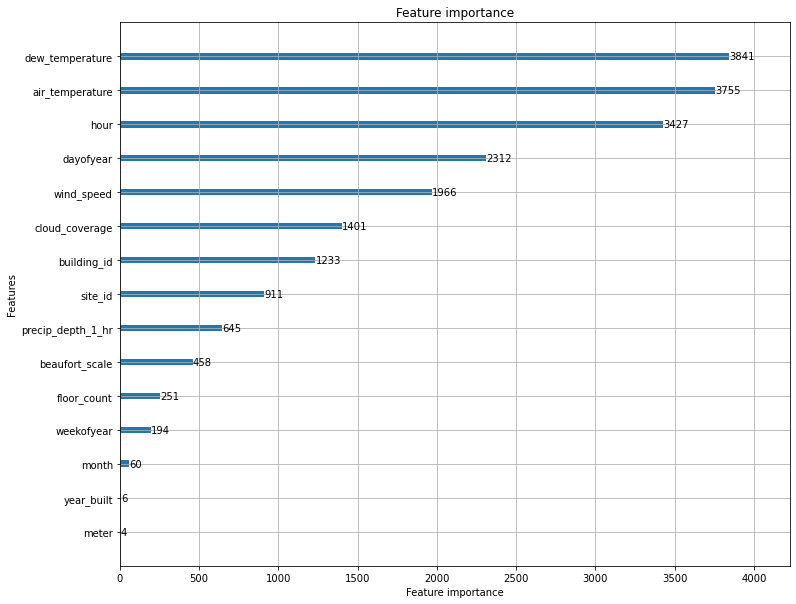

In [13]:
i = 0
scores = []
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
          
    X_test = X.iloc[test_index]    
    y_test = y.iloc[test_index]
    
    y_pred = models[i].predict(X_test)
    scores.append(np.sum(np.absolute(y_test - y_pred)) / np.sum(y_test))
    i += 1
    
    fig, axes = plt.subplots(figsize=(20, 4))
    (y_pred / y_test).plot() 
    
print('Scores:')
print_results(scores)
plot_importances(models)   